## Import Libraries

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

## Read Data

In [2]:
# Example dataset loading
data = pd.read_csv('European Restaurant Reviews.csv')
data.head()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...


## Analysis & Visualization

In [3]:
# Remove duplicates
data.drop_duplicates(inplace=True)
data.drop_duplicates(inplace=True)

# Remove null values
data.dropna(subset=['Review'], inplace=True)
data.dropna(subset=['Review'], inplace=True)

In [4]:
# English text normalization
def normalize_english(text):
    # Normalize common typos and informal expressions if needed
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    return text

# Remove repeated characters
def remove_repeated_chars(text):
    text = re.sub(r'(.)\1+', r'\1', text)
    return text

# Remove URLs, mentions, hashtags, and extra whitespace
def clean_text(text):
    text = re.sub(r'http\S+', '', text)    # Remove URLs
    text = re.sub(r'@\S+', '', text)       # Remove mentions
    text = re.sub(r'#\S+', '', text)       # Remove hashtags
    text = text.strip()                   # Remove leading and trailing whitespace
    return text

# Tokenization and stop words removal
nltk.download('stopwords')
english_stopwords = set(stopwords.words("english"))

def preprocess_text(text):
    text = normalize_english(text)
    text = remove_repeated_chars(text)
    text = clean_text(text)
    text = ' '.join([word for word in text.split() if word not in english_stopwords])
    return text

# Apply preprocessing
data['Review'] = data['Review'].apply(preprocess_text)

# Convert Sentiment labels to binary (0: Negative, 1: Positive)
data['Sentiment'] = data['Sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)

# Optional: Split train_df into train and validation sets if needed
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

print("Text preprocessing complete.")

Text preprocessing complete.


[nltk_data] Downloading package stopwords to C:\Users\Mohamed
[nltk_data]     Abdalkader\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


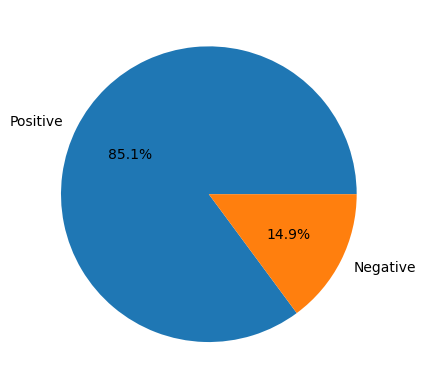

In [5]:
value_counts = data["Sentiment"].value_counts()
plt.pie(value_counts, labels=["Positive", "Negative"], autopct='%1.1f%%')
plt.show()

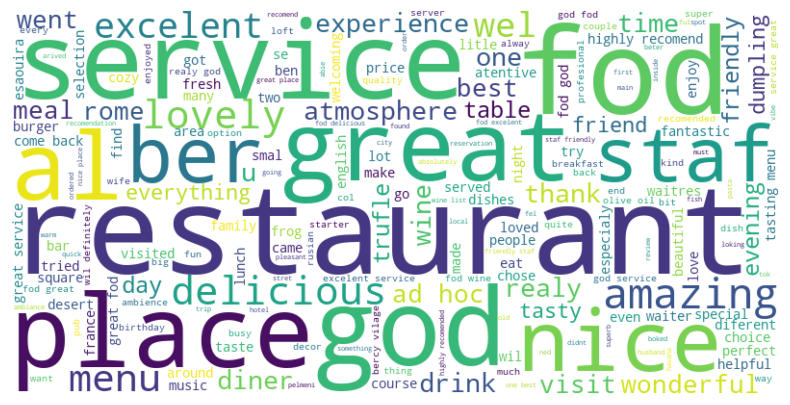

In [6]:
# Combine all reviews into a single string
all_reviews = " ".join(data[data["Sentiment"] == 1]['Review'].astype(str).tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

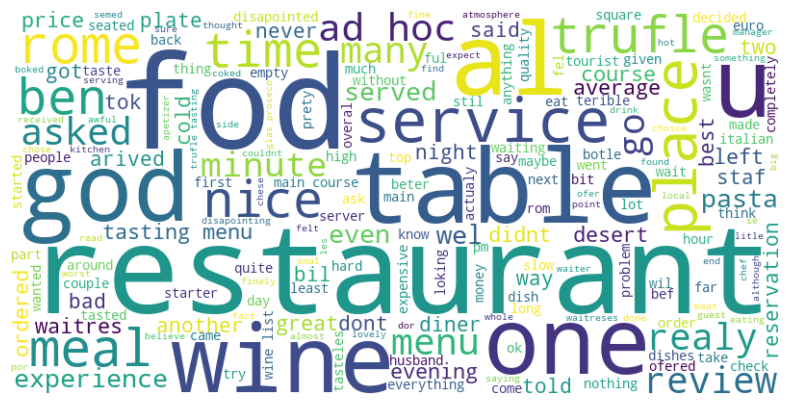

In [7]:
# Combine all reviews into a single string
all_reviews = " ".join(data[data["Sentiment"] == 0]['Review'].astype(str).tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()


In [8]:
X = data['Review']
y = data['Sentiment']  # 'positive' or 'negative'

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Vectorize text
# vectorizer = TfidfVectorizer()
# X_train_vec = vectorizer.fit_transform(X_train)
# X_test_vec = vectorizer.transform(X_test)

## Modeling

### Machine Learning

In [9]:
# Define the pipeline for machine learning
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text to TF-IDF features
    ('clf', LogisticRegression())  # Classifier
])

# Training the model
pipeline.fit(X_train, y_train)

# Predicting on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Machine Learning Model Evaluation")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Machine Learning Model Evaluation
Accuracy: 0.9038
              precision    recall  f1-score   support

           0       1.00      0.26      0.42        38
           1       0.90      1.00      0.95       253

    accuracy                           0.90       291
   macro avg       0.95      0.63      0.68       291
weighted avg       0.91      0.90      0.88       291



### Deep Learning

In [10]:
# Parameters
MAX_NUM_WORDS = 10000  # Vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Maximum sequence length
EMBEDDING_DIM = 100  # Embedding dimensions

# Tokenization and padding
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded)
print("Deep Learning Model Evaluation")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.7997 - loss: 0.5668 - val_accuracy: 0.8841 - val_loss: 0.3363
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8562 - loss: 0.3318 - val_accuracy: 0.9013 - val_loss: 0.2902
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9139 - loss: 0.2719 - val_accuracy: 0.9399 - val_loss: 0.1954
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9747 - loss: 0.0840 - val_accuracy: 0.9399 - val_loss: 0.1399
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9951 - loss: 0.0262 - val_accuracy: 0.9485 - val_loss: 0.1582
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9604 - loss: 0.1667
Deep Learning Model Evaluation
Test Accuracy: 0.9691


In [11]:
# Predicting on the test set
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert predictions back to original labels
y_pred = y_pred.flatten()
y_test_encoded = np.array(y_test_encoded)

print(classification_report(y_test_encoded, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
              precision    recall  f1-score   support

           0       0.94      0.82      0.87        38
           1       0.97      0.99      0.98       253

    accuracy                           0.97       291
   macro avg       0.96      0.90      0.93       291
weighted avg       0.97      0.97      0.97       291

